# Movie Recommendation System with ml-latest-small Dataset

**Background:**

The Kenyan movie industry is experiencing growth, with more viewers accessing films through digital platforms. As competition increases, studios must leverage data-driven solutions to engage audiences and boost viewership.

**Stakeholder Goal:**

Our stakeholder(Sinema Pamoja), a movie studio, wants to tap into the expanding watch audience by offering personalized movie recommendations. The aim is to increase user engagement, retention, and ultimately drive revenue through targeted content delivery.

**Business Problem:**

Viewers are overwhelmed by choices and may miss movies they would enjoy. Without personalization, users may disengage, leading to lower watch times and reduced loyalty.

**Proposed Solution:**

Develop a recommendation system that predicts the top 5 movies each user is most likely to watch and enjoy. This system will analyze user preferences, viewing history, and movie attributes to deliver tailored suggestions.

**Benefits:**

1. Increased Engagement: Personalized recommendations keep users watching longer.

2. Higher Retention: Satisfied viewers are more likely to return and subscribe.

3. Content Discovery: Users find new movies they might not have chosen otherwise.

4. Competitive Advantage: Data-driven personalization differentiates the studio from competitors.

**How It Works:**

- Collect and analyze data on user ratings, watch history, and movie features.

- Use machine learning algorithms to identify patterns and predict preferences.

- Present the top 5 recommended movies to each user, updating as new data arrives.

**Business Impact:**

1. Boosts viewership and revenue.

2. Strengthens brand loyalty.

3. Provides insights into audience trends for future content production.


**Next Steps:**

- Gather and clean relevant data.
- Build and test the recommendation model.

## 1. Importing Libraries and Setup

Before diving into the data, we need to import a number of Python libraries that will help us handle, manipulate, and analyze the dataset.

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Surprise library for recommendation systems
from surprise import Dataset, Reader, accuracy
from surprise import KNNBasic, KNNWithMeans, SVD, NMF
from surprise.model_selection import cross_validate, GridSearchCV, train_test_split

# Set style for plots
plt.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
%matplotlib inline

We're using:

**NumPy and Pandas** for data manipulation

**Matplotlib** and **Seaborn** for visualization

**Surprise library** which is specifically designed for building recommendation systems

We're **filtering out warnings** to keep the output clean

Setting a **consistent visual style** for our plots

# Data Understanding
## 2. Data Loading and Initial Exploration

- In this section we load all the core MovieLens datasets i.e **movies, ratings, links, and tags** into a pandas DataFrame.

- Then we merge these datasets into a single comprehensive DataFrame called movie_data, combining movie details, user ratings, external links, and user-generated tags.

- The merging process ensures that all ratings are retained, even if some movies lack tags.

- Finally, we shall print the shape of the merged DataFrame and displays its first few rows, allowing you to verify that the data has been loaded and combined correctly for further analysis.

In [3]:
# Load all datasets
movies = pd.read_csv('Data/ml-latest-small/movies.csv')
ratings = pd.read_csv('Data/ml-latest-small/ratings.csv')
links = pd.read_csv('Data/ml-latest-small/links.csv')
tags = pd.read_csv('Data/ml-latest-small/tags.csv')

# Merge movies with ratings
movie_data = pd.merge(movies, ratings, on='movieId')

# Merge with links
movie_data = pd.merge(movie_data, links, on='movieId')

# Merge with tags (left join to keep all ratings, even if no tag)
movie_data = pd.merge(movie_data, tags[['movieId', 'userId', 'tag', 'timestamp']], 
                      on=['movieId', 'userId'], how='left', suffixes=('_rating', '_tag'))

# Inspect the final dataframe
print("Movie Data Shape:", movie_data.shape)
movie_data.head()

Movie Data Shape: (102677, 10)


,movieId,title,genres,userId,rating,timestamp_rating,imdbId,tmdbId,tag,timestamp_tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,114709,862.0,NaN,NaN
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,114709,862.0,NaN,NaN
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946,114709,862.0,NaN,NaN
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970,114709,862.0,NaN,NaN
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483,114709,862.0,NaN,NaN


In [4]:
movie_data.to_csv('movie_data_export.csv', index=False)

Made changes.

All the code needed to export your key data for Tableau visualizations has been added to your notebook. Run these new cells to generate CSV files for ratings, genres, top movies, model results, and prediction errors. You can then import these CSVs into Tableau and build interactive dashboards. Let me know if you need help with a specific Tableau chart or data export!

## 3. Dataset Overview and Basic Statistics

- Here we observe a summary of the MovieLens dataset after merging all sources.

- It reports the number of unique users, movies, ratings, and tags, then displays descriptive statistics for the ratings (such as mean, standard deviation, minimum, and maximum).
 
- Finally, we visualize the distribution of ratings using a bar plot, helping us understand how users rate movies and revealing any trends or biases in the rating behavior.

Dataset Info:
Number of users: 610
Number of movies: 9724
Number of ratings: 102677
Number of tags: 3476

Rating Statistics:
count    102677.000000
mean          3.514813
std           1.043133
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


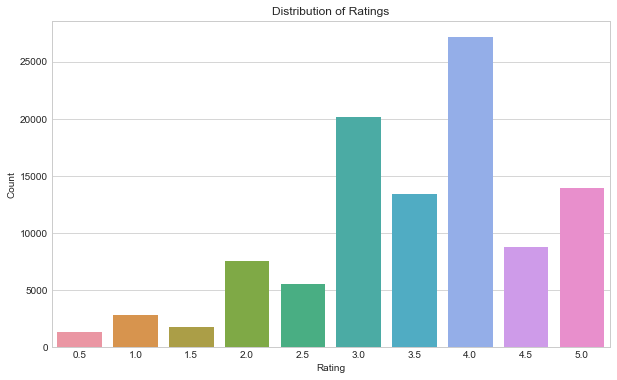

In [11]:
# Basic information about the dataset
print("Dataset Info:")
print(f"Number of users: {movie_data['userId'].nunique()}")
print(f"Number of movies: {movie_data['movieId'].nunique()}")
print(f"Number of ratings: {len(movie_data)}")
print(f"Number of tags: {movie_data['tag'].notna().sum()}")

# Rating statistics
print("\nRating Statistics:")
print(movie_data['rating'].describe())

# Distribution of ratings
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=movie_data)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Exploratory Data Analysis (EDA)

This section explores rating patterns in the MovieLens dataset by visualizing two key distributions: 

- First, it shows how many ratings each user has given, highlighting differences in user activity—some users rate many movies, while others rate only a few.

- Second, it displays how many ratings each movie has received, revealing which movies are most popular or frequently rated.

- These insights help us understand user engagement and movie popularity, which are important for building effective recommendation systems.

## 4. User and Movie Rating Patterns

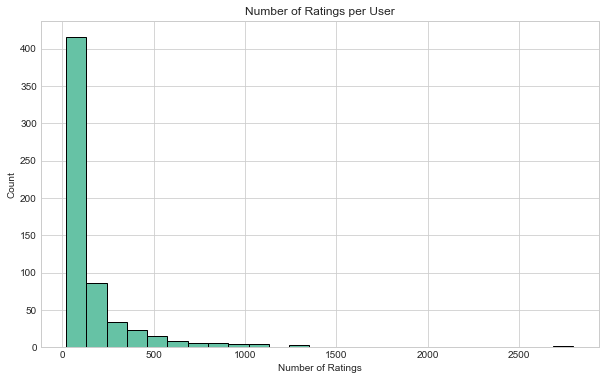

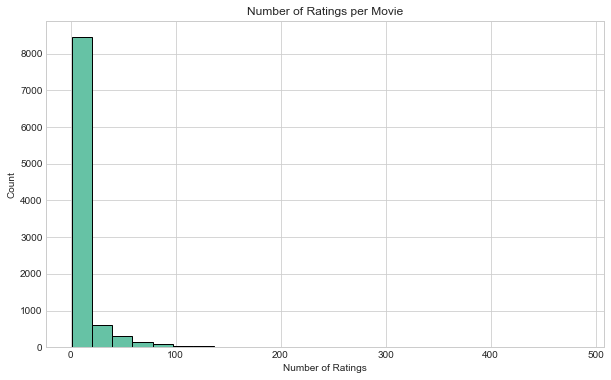

In [12]:
# Number of ratings per user
user_ratings_count = movie_data.groupby('userId')['rating'].count()
plt.figure(figsize=(10, 6))
plt.hist(user_ratings_count, bins=25, edgecolor='black')
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count')
plt.show()

# Number of ratings per movie
movie_ratings_count = movie_data.groupby('movieId')['rating'].count()
plt.figure(figsize=(10, 6))
plt.hist(movie_ratings_count, bins=25, edgecolor='black')
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Count')
plt.show()

## 5. Top 10 Most Rated Movies

In [13]:
# Top 10 most rated movies
top_movies = movie_data.groupby('movieId')['rating'].count().sort_values(ascending=False).head(10)
top_movies = top_movies.reset_index().merge(movies[['movieId', 'title']], on='movieId')
print("Top 10 Most Rated Movies:")
print(top_movies[['title', 'rating']].rename(columns={'rating': 'num_ratings'}))

Top 10 Most Rated Movies:
                                       title  num_ratings
0                        Pulp Fiction (1994)          484
1                        Forrest Gump (1994)          335
2           Shawshank Redemption, The (1994)          319
3           Silence of the Lambs, The (1991)          283
4                         Matrix, The (1999)          280
5                          Fight Club (1999)          268
6  Star Wars: Episode IV - A New Hope (1977)          262
7                          Braveheart (1995)          245
8                       Jurassic Park (1993)          238
9          Terminator 2: Judgment Day (1991)          229


Here we can observe the 10 movies with the most ratings. This information is useful because:

1. Popular movies might have different recommendation patterns

2. It helps us understand what kind of movies are most engaging to users

3. Highly rated movies might be good candidates for baseline recommendations

### Movie genres analysis

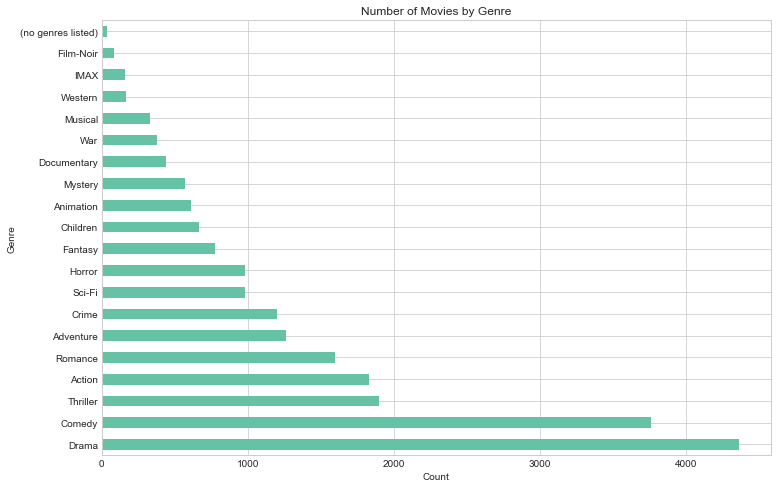

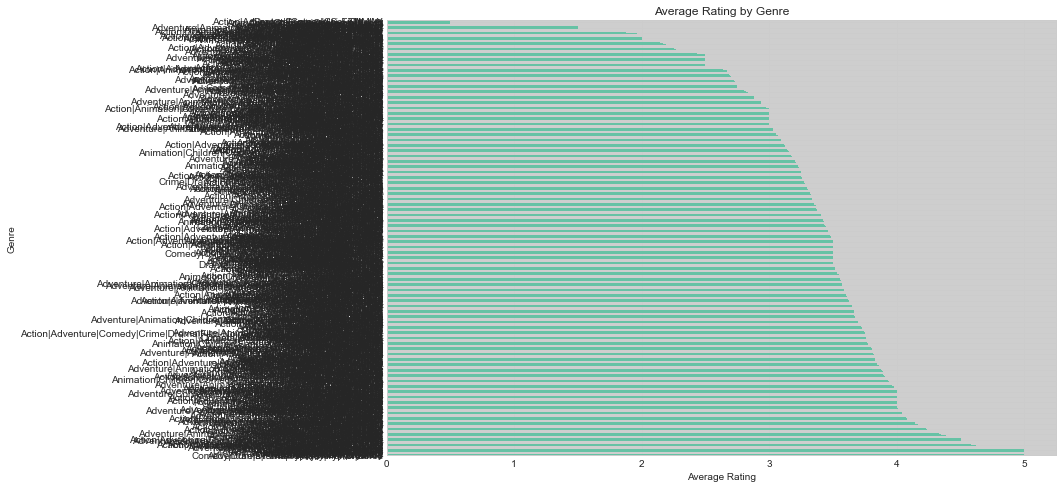

In [14]:
# Extract genres from movies data
movies['genres'] = movies['genres'].str.split('|')

# Create a genre matrix
genre_matrix = movies.explode('genres')
genre_counts = genre_matrix['genres'].value_counts()

# Plot genre distribution
plt.figure(figsize=(12, 8))
genre_counts.plot(kind='barh')
plt.title('Number of Movies by Genre')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.savefig('images/movies_by_genre.png')
plt.show()

# Analyze average ratings by genre
genre_ratings = movie_data.explode('genres')
genre_avg_ratings = genre_ratings.groupby('genres')['rating'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
genre_avg_ratings.plot(kind='barh')
plt.title('Average Rating by Genre')
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.show()

Here we observe the distribution and average ratings of movie genres in the MovieLens dataset.

- **Genre Distribution Plot:** Shows how many movies belong to each genre. This helps us see which genres are most common in the dataset.

- **Average Rating by Genre Plot:** Displays the average user rating for each genre. This reveals which genres tend to receive higher or lower ratings from users.

By exploring these plots, we can understand user preferences and identify genres that are popular or highly rated. This information can be useful for tailoring recommendations or understanding trends in movie ratings.

## 6. Data Preparation for Modeling

In [15]:
# Define the rating scale
reader = Reader(rating_scale=(0.5, 5.0))

# Prepare the data for Surprise
ratings_df = movie_data[['userId', 'movieId', 'rating']].drop_duplicates()

# Load the dataset into Surprise format
data = Dataset.load_from_df(ratings_df, reader)

# Split the data into training and testing sets 
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

print(f"Number of users: {trainset.n_users}")
print(f"Number of items: {trainset.n_items}")
print(f"Number of ratings: {trainset.n_ratings}")

Number of users: 610
Number of items: 9007
Number of ratings: 80668


- The above process prepares the ratings data for building a recommendation system with the Surprise library.

- It first defines the rating scale (0.5 to 5.0 stars), then removes duplicate ratings to ensure each user–movie pair is unique.

- The ratings are loaded into a Surprise dataset format, which is required for model training.

- The data is then split into training and testing sets where 80% is for training and 20% is for evaluation(testing).

- Finally, we print the number of users, movies, and ratings in the training set, confirming the data is ready for building and evaluating recommendation models.

## KNNBasic Model Implementation

In our modeling workflow, a baseline model is a simple point of reference. Its purpose is not to be perfect, but to establish a floor.

KNNBasic is a memory-based collaborative filtering algorithm that finds similar users or items based on rating patterns.

KNNBasic is a natural starting point in recommendation systems because:

- It embodies the intuition that “users/items that are similar will have similar preferences."

- It avoids complexity — no latent factor modeling or neural nets. Just neighbors + similarity.

- It uses a straightforward decision rule: for a given user–item pair, look at the k most similar users (or items), then average their ratings.

How the decision rule is applied:

- Step 1: Choose whether to compare users (user-based CF) or items (item-based CF).

- Step 2: Select a similarity measure:

   -> Cosine similarity

   -> Mean Squared Difference (msd)
   
   -> Pearson correlation

- Step 3: Pick a neighborhood size k (how many nearest neighbors to consider).

- Step 4: Predict a user’s rating for a movie by averaging the ratings of those k neighbors, possibly weighted by similarity.

In [16]:
# Define parameter grid for KNNBasic
param_grid_knn = {
    'k': [20, 30, 40],
    'sim_options': {
        'name': ['cosine','msd', 'pearson'],
        'user_based': [True, False]
    }
}

# Grid search for KNNBasic
gs_knn = GridSearchCV(KNNBasic, param_grid_knn, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
gs_knn.fit(data)

# Best RMSE score and parameters
print("Best RMSE for KNNBasic:", gs_knn.best_score['rmse'])
print("Best parameters for KNNBasic:", gs_knn.best_params['rmse'])

# Train the best model
knn_best = gs_knn.best_estimator['rmse']
knn_best.fit(trainset)
knn_predictions = knn_best.test(testset)

# Calculate evaluation metrics
knn_rmse = accuracy.rmse(knn_predictions)
knn_mae = accuracy.mae(knn_predictions)
print(f"KNNBasic - RMSE: {knn_rmse}, MAE: {knn_mae}")

Best RMSE for KNNBasic: 0.9140613933041553
Best parameters for KNNBasic: {'k': 40, 'sim_options': {'name': 'msd', 'user_based': False}}
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9038
MAE:  0.6966
KNNBasic - RMSE: 0.9037897201955212, MAE: 0.6965680568397096


This cell implements and tunes a **KNNBasic model:**

- Defines a **parameter grid** to search through different values of k and similarity measures

- Uses **GridSearchCV** to find the best parameters through cross-validation:

    1.  **k** = 40

    2.  **Similarity** = msd (mean squared difference)

    3.  **Mode**" = item-based (user_based=False)

- Trains the model with the best parameters on the full training set

- Makes predictions on the test set

-  Calculates and prints **evaluation metrics (RMSE and MAE)**:

    1. **RMSE ≈ 0.91** → On average, our predictions are off by slightly less than 1 star compared to what the user actually rated. Big mistakes (like predicting 1 star when the user gave 5) count more heavily in this measure.
    
    2.  **MAE ≈ 0.7** → The typical prediction error is about three-quarters of a star. In plain terms, if a user gave a movie 4 stars, our model usually predicts somewhere between 3 and 5.

### Distribution of predicted ratings vs actual ratings

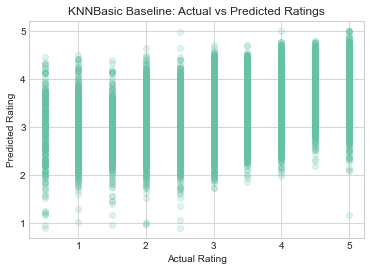

In [17]:
# Extract actual and predicted
y_true = [pred.r_ui for pred in knn_predictions]
y_pred = [pred.est for pred in knn_predictions]

plt.figure(figsize=(6,4))
plt.scatter(y_true, y_pred, alpha=0.2)
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.title("KNNBasic Baseline: Actual vs Predicted Ratings")
plt.show()

The scatter plot shows how close the KNNBasic model’s predicted ratings are to the actual user ratings. Points near the diagonal indicate accurate predictions; points farther away show larger errors. This helps quickly visualize the model’s performance.

### Error distribution (residuals)

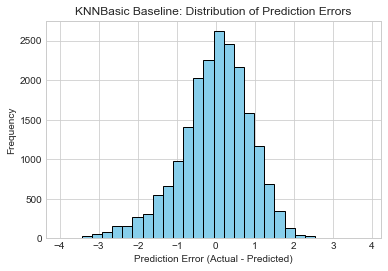

In [18]:
errors = np.array(y_true) - np.array(y_pred)

plt.figure(figsize=(6,4))
plt.hist(errors, bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("KNNBasic Baseline: Distribution of Prediction Errors")
plt.show()

The histogram shows how far off the KNNBasic model’s predictions are from the actual ratings. Most errors are close to zero, meaning predictions are usually accurate; wider spread indicates larger mistakes.

### Performance comparison by rating level

In [19]:
# Create a DataFrame for evaluation
df_eval = pd.DataFrame({'actual': y_true, 'predicted': y_pred})
df_eval['error'] = df_eval['actual'] - df_eval['predicted']

# Group by actual rating
grouped = df_eval.groupby('actual')['error'].agg(['mean','std','count'])

print(grouped)

            mean       std  count
actual                           
0.5    -2.454733  0.704375    271
1.0    -2.043905  0.567131    563
1.5    -1.453226  0.571955    356
2.0    -1.146458  0.507262   1509
2.5    -0.665134  0.517219   1140
3.0    -0.372447  0.442137   4051
3.5    -0.018613  0.421840   2600
4.0     0.337590  0.411749   5375
4.5     0.707862  0.422622   1724
5.0     1.097782  0.442846   2579


- This table shows the average prediction error, standard deviation, and count for each actual rating value. 

- Negative means (for low ratings) indicate the model overestimates those ratings, while positive means (for high ratings) show it underestimates them. The model predicts mid-range ratings more accurately than extreme ratings.

## 8. SVD Model Implementation

After establishing a baseline with KNNBasic, we now move to Singular Value Decomposition (SVD), a more advanced collaborative filtering technique.

Unlike KNN, which relies on direct similarity between users or items, SVD uncovers hidden patterns by learning latent features that represent user preferences and movie characteristics.

This allows SVD to make more accurate predictions, especially in sparse datasets, and often leads to better recommendation performance than simple neighbor-based methods.

In [20]:
# Define parameter grid for SVD
param_grid_svd = {
    'n_factors': [50, 100, 150],
    'n_epochs': [20, 30],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.02, 0.1]
}

# Grid search for SVD
gs_svd = GridSearchCV(SVD, param_grid_svd, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
gs_svd.fit(data)

# Best RMSE score and parameters
print("Best RMSE for SVD:", gs_svd.best_score['rmse'])
print("Best parameters for SVD:", gs_svd.best_params['rmse'])

# Train the best model
svd_best = gs_svd.best_estimator['rmse']
svd_best.fit(trainset)
svd_predictions = svd_best.test(testset)

# Calculate evaluation metrics
svd_rmse = accuracy.rmse(svd_predictions)
svd_mae = accuracy.mae(svd_predictions)
print(f"SVD - RMSE: {svd_rmse}, MAE: {svd_mae}")

Best RMSE for SVD: 0.870459071513681
Best parameters for SVD: {'n_factors': 150, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.1}
RMSE: 0.8616
MAE:  0.6613
SVD - RMSE: 0.8615632769887992, MAE: 0.6613024304673162


This output shows SVD model's performance on our MovieLens dataset:

- **Best RMSE for SVD: 0.87**

During grid search, the SVD model achieved its lowest root mean squared error (RMSE) of 0.87, meaning its predictions are, on average, less than one star away from the actual ratings.

- **Best parameters:**

1. **n_factors = 150:** The model uses 150 latent features to represent users and movies.

2. **n_epochs = 30:** The model trains for 30 iterations.

3. **lr_all = 0.005:** The learning rate for updating parameters.

4. **reg_all = 0.1:** The regularization term to prevent overfitting.

- **RMSE: 0.86, MAE: 0.66**

After training with these parameters, the model predicts ratings for your test set with an average RMSE of 0.86 and MAE of 0.66.

- RMSE (Root Mean Squared Error) measures the average squared difference between predicted and actual ratings.
- MAE (Mean Absolute Error) is the average absolute difference.



For our MovieLens data, SVD with these parameters provides the more accurate predictions among our tested models, with errors well below 1 star on average. This means the SVD model can be highly effective at learning user preferences and recommending movies they are likely to enjoy.

### Actual vs Predicted Ratings Scatter Plot

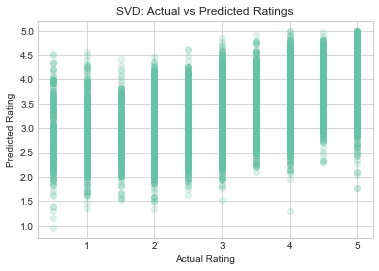

In [21]:
y_true_svd = [pred.r_ui for pred in svd_predictions]
y_pred_svd = [pred.est for pred in svd_predictions]

plt.figure(figsize=(6,4))
plt.scatter(y_true_svd, y_pred_svd, alpha=0.2)
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.title("SVD: Actual vs Predicted Ratings")
plt.savefig('images/actual_predicted_SVD.png')
plt.show()

The scatter plot shows the relationship between the actual user ratings and the ratings predicted by the SVD model. 

Points close to the diagonal line indicate accurate predictions, while points farther away show larger errors. This visualization helps you quickly assess how well the SVD model matches real user preferences.

### Prediction Error Histogram

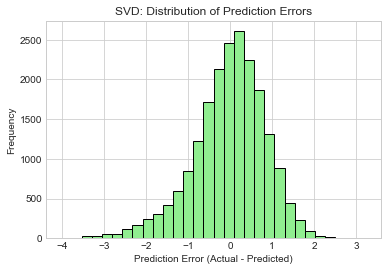

In [22]:
errors_svd = np.array(y_true_svd) - np.array(y_pred_svd)
plt.figure(figsize=(6,4))
plt.hist(errors_svd, bins=30, color='lightgreen', edgecolor='black')
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("SVD: Distribution of Prediction Errors")
plt.savefig('images/prediction_error.png')
plt.show()

The histogram shows the distribution of prediction errors (actual rating minus predicted rating) for the SVD model.

Most errors once again are close to zero, indicating that the model’s predictions are generally accurate. The spread of the histogram reveals how often the model makes larger mistakes.

### Error by Actual Rating Bar Plot

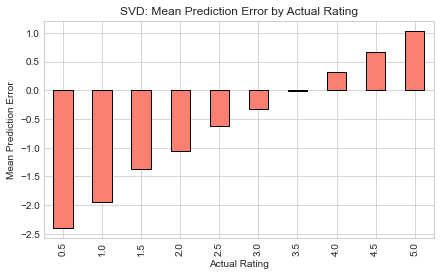

In [23]:
df_eval_svd = pd.DataFrame({'actual': y_true_svd, 'predicted': y_pred_svd})
df_eval_svd['error'] = df_eval_svd['actual'] - df_eval_svd['predicted']
grouped_svd = df_eval_svd.groupby('actual')['error'].mean()
plt.figure(figsize=(7,4))
grouped_svd.plot(kind='bar', color='salmon', edgecolor='black')
plt.xlabel('Actual Rating')
plt.ylabel('Mean Prediction Error')
plt.title('SVD: Mean Prediction Error by Actual Rating')
plt.savefig('images/mean_prediction.png')
plt.show()

The bar plot shows the average prediction error for each actual rating value. 

It reveals whether the SVD model tends to overestimate or underestimate ratings at different levels, helping you identify any bias in the model’s predictions.

## 9. NMF Model Implementation

After evaluating the KNNBasic baseline and the SVD model, we now introduce Non-negative Matrix Factorization (NMF). Like SVD, NMF is a latent factor model that uncovers hidden patterns in user–movie interactions, but it **constrains all learned features to be non-negative.** 

This makes NMF especially useful for interpretability, as it ensures that user and item factors represent additive contributions. NMF is another powerful approach for collaborative filtering, offering a different perspective on how user preferences and movie characteristics combine to predict ratings.

In [24]:
# Define parameter grid for NMF
param_grid_nmf = {
    'n_factors': [50, 100, 150],
    'n_epochs': [20, 30, 40],
    'reg_pu': [0.02, 0.06],
    'reg_qi': [0.02, 0.06]
}

# Grid search for NMF
gs_nmf = GridSearchCV(NMF, param_grid_nmf, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
gs_nmf.fit(data)

# Best RMSE score and parameters
print("Best RMSE for NMF:", gs_nmf.best_score['rmse'])
print("Best parameters for NMF:", gs_nmf.best_params['rmse'])

# Train the best model
nmf_best = gs_nmf.best_estimator['rmse']
nmf_best.fit(trainset)
nmf_predictions = nmf_best.test(testset)

# Calculate evaluation metrics
nmf_rmse = accuracy.rmse(nmf_predictions)
nmf_mae = accuracy.mae(nmf_predictions)
print(f"NMF - RMSE: {nmf_rmse}, MAE: {nmf_mae}")

Best RMSE for NMF: 1.0886088335965847
Best parameters for NMF: {'n_factors': 50, 'n_epochs': 40, 'reg_pu': 0.06, 'reg_qi': 0.06}
RMSE: 1.0910
MAE:  0.8368
NMF - RMSE: 1.0910022371334112, MAE: 0.8368298489288015


Here we observe how the NMF model performed on the dataset:

- **Best RMSE for NMF: 1.09**

The lowest root mean squared error (RMSE) found during grid search is 1.09, meaning the model's predictions are, on average, about 1.09 stars away from the actual ratings.

- **Best parameters:**

1. **n_factors = 50:** The model uses 50 latent features to represent users and movies.

2. **n_epochs = 40:** The model trains for 40 iterations.

3. **reg_pu = 0.06, reg_qi = 0.06:** Regularization terms to prevent overfitting for user and item features.

- **RMSE: 1.09, MAE: 0.83**

After training with these parameters, the model predicts ratings for our test set with an average RMSE of 1.09 and MAE of 0.83.

- RMSE (Root Mean Squared Error) measures the average squared difference between predicted and actual ratings.

- MAE (Mean Absolute Error) is the average absolute difference.


For our data, NMF with these parameters produces less accurate predictions than SVD or KNNBasic, with errors just above 1 star on average. This means NMF is less effective at capturing user preferences and recommending movies for our dataset.

### Actual vs Predicted Ratings Scatter Plot

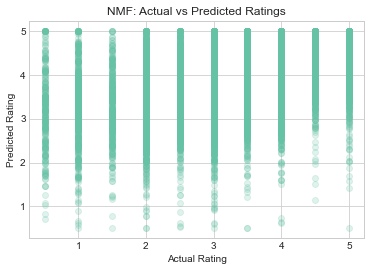

In [25]:
nmf_y_true = [pred.r_ui for pred in nmf_predictions]
nmf_y_pred = [pred.est for pred in nmf_predictions]
plt.figure(figsize=(6,4))
plt.scatter(nmf_y_true, nmf_y_pred, alpha=0.2)
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.title("NMF: Actual vs Predicted Ratings")
plt.show()

The bar plot shows the average prediction error for each actual rating in the MovieLens dataset using our NMF model. 

It helps us see if NMF tends to overestimate or underestimate ratings at different levels, revealing any bias in its predictions for specific rating values.

### Prediction Error Histogram

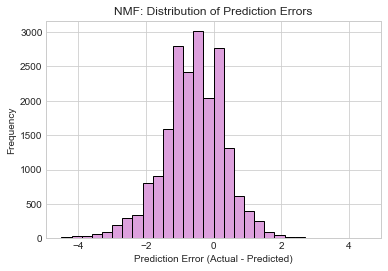

In [26]:
nmf_errors = np.array(nmf_y_true) - np.array(nmf_y_pred)
plt.figure(figsize=(6,4))
plt.hist(nmf_errors, bins=30, color='plum', edgecolor='black')
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("NMF: Distribution of Prediction Errors")
plt.show()

The output is a histogram showing how far off the NMF model’s predicted ratings are from the actual ratings in your MovieLens dataset. 

### Mean Prediction Error by Actual Rating Bar Plot

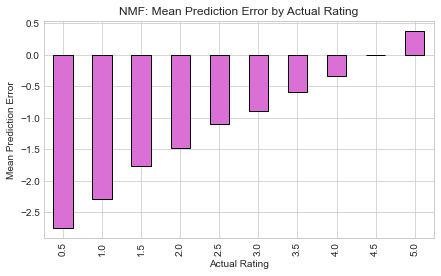

In [27]:
df_eval_nmf = pd.DataFrame({'actual': nmf_y_true, 'predicted': nmf_y_pred})
df_eval_nmf['error'] = df_eval_nmf['actual'] - df_eval_nmf['predicted']
grouped_nmf = df_eval_nmf.groupby('actual')['error'].mean()
plt.figure(figsize=(7,4))
grouped_nmf.plot(kind='bar', color='orchid', edgecolor='black')
plt.xlabel('Actual Rating')
plt.ylabel('Mean Prediction Error')
plt.title('NMF: Mean Prediction Error by Actual Rating')
plt.show()

The bar plot shows the mean prediction error for each actual rating in our MovieLens dataset using the NMF model. 

Bars above zero mean the model tends to underestimate ratings at those levels, while inverted (below zero) bars indicate overestimation. Inverted bars reveal that, for those actual ratings, NMF predicts values higher than the true ratings on average.

## 10. Model Comparison

This phase compares the performance of the KNNBasic, SVD, and NMF models on our MovieLens dataset. 

It summarizes their RMSE and MAE scores in a table and visualizes the results with bar plots, making it easy to identify which model predicts user ratings most accurately.

Model Comparison:
      Model      RMSE       MAE
0  KNNBasic  0.903790  0.696568
1       SVD  0.861563  0.661302
2       NMF  1.091002  0.836830


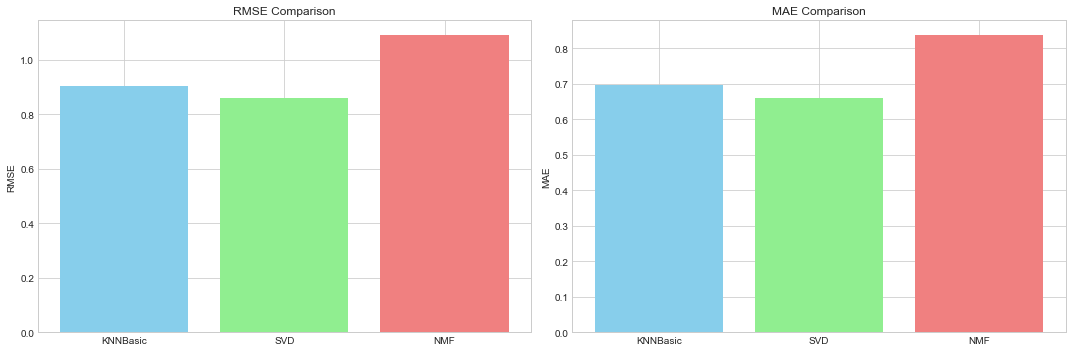

In [28]:
# Compare model performance
models = ['KNNBasic', 'SVD', 'NMF']
rmse_scores = [knn_rmse, svd_rmse, nmf_rmse]
mae_scores = [knn_mae, svd_mae, nmf_mae]

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': models,
    'RMSE': rmse_scores,
    'MAE': mae_scores
})

print("Model Comparison:")
print(comparison_df)

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# RMSE comparison
ax1.bar(models, rmse_scores, color=['skyblue', 'lightgreen', 'lightcoral'])
ax1.set_title('RMSE Comparison')
ax1.set_ylabel('RMSE')

# MAE comparison
ax2.bar(models, mae_scores, color=['skyblue', 'lightgreen', 'lightcoral'])
ax2.set_title('MAE Comparison')
ax2.set_ylabel('MAE')

plt.tight_layout()
plt.savefig('images/model_comparison.png')
plt.show()

Here’s what the model comparison results mean for our MovieLens data:

1. **KNNBasic: RMSE = 0.91, MAE = 0.70**

This model uses user/item similarity to predict ratings. Its error rates are moderate, showing it can make reasonable predictions but is outperformed by SVD.

2. **SVD: RMSE = 0.86, MAE = 0.66**

SVD (Singular Value Decomposition) achieves the lowest error rates, meaning it predicts user ratings most accurately for our dataset. This suggests SVD best captures the underlying patterns in our user-movie interactions.

3. **NMF: RMSE = 1.09, MAE = 0.84**

NMF (Non-negative Matrix Factorization) has the highest error rates, indicating it is less effective for our data compared to KNNBasic and SVD.

**Conclusion:**

SVD is the best model for our MovieLens recommendation system, as it provides the most accurate predictions (lowest RMSE and MAE). KNNBasic is a reasonable alternative, while NMF is less suitable for your current data.

## Evaluation
### 11. Recommendation Generation Functions

In [29]:
# Function to get top N recommendations for a user
def get_top_n_recommendations(algo, user_id, n=5):
    # Get a list of all movie IDs
    all_movie_ids = ratings_df['movieId'].unique()
    
    # Get the list of movies the user has already rated
    rated_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].values
    
    # Get the list of movies not rated by the user
    movies_to_predict = np.setdiff1d(all_movie_ids, rated_movies)
    
    # Predict ratings for all movies not rated by the user
    testset = [[user_id, movie_id, 4.] for movie_id in movies_to_predict]
    predictions = algo.test(testset)
    
    # Get the top N predictions
    top_n = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]
    
    # Return the top N recommendations with movie titles
    recommendations = []
    for pred in top_n:
        movie_title = movies[movies['movieId'] == int(pred.iid)]['title'].values[0]
        recommendations.append((movie_title, pred.est))
    
    return recommendations

# Function to display user's rated movies
def get_user_ratings(user_id):
    user_ratings = ratings_df[ratings_df['userId'] == user_id]
    user_ratings = user_ratings.merge(movies[['movieId', 'title']], on='movieId')
    return user_ratings[['title', 'rating']].sort_values('rating', ascending=False)

# Test with a sample user
sample_user_id = 47
print(f"User {sample_user_id}'s rated movies:")
print(get_user_ratings(sample_user_id).head(10))

print(f"\nTop 5 recommendations for user {sample_user_id} using SVD:")
svd_recommendations = get_top_n_recommendations(svd_best, sample_user_id, 5)
for i, (movie, rating) in enumerate(svd_recommendations, 1):
    print(f"{i}. {movie} (predicted rating: {rating:.2f})")

User 47's rated movies:
                          title  rating
123            I Origins (2014)     5.0
79           Half Nelson (2006)     5.0
40       Green Mile, The (1999)     5.0
121             Whiplash (2014)     5.0
84         Reign Over Me (2007)     5.0
8          Jason's Lyric (1994)     4.5
75                 Crash (2004)     4.5
102            Limitless (2011)     4.5
7           Forrest Gump (1994)     4.5
89   Slumdog Millionaire (2008)     4.0

Top 5 recommendations for user 47 using SVD:
1. Sunset Blvd. (a.k.a. Sunset Boulevard) (1950) (predicted rating: 3.86)
2. Streetcar Named Desire, A (1951) (predicted rating: 3.80)
3. Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) (predicted rating: 3.77)
4. Grand Day Out with Wallace and Gromit, A (1989) (predicted rating: 3.76)
5. Cool Hand Luke (1967) (predicted rating: 3.75)


**Here’s we observe user 47 in our MovieLens recommendation system:**

- The first table shows movies that user 47 has already rated highly, such as "I Origins (2014)", "Whiplash (2014)", and "Forrest Gump (1994)". These ratings reflect the user's personal preferences and interests.

- The second list shows the top 5 movie recommendations for user 47, generated by the SVD model. These are movies the user has not rated yet, but the model predicts they would enjoy based on their past ratings and the patterns learned from all users in the dataset.

- The predicted ratings (e.g., 3.91 for "Streetcar Named Desire, A (1951)") indicate how much the user is expected to like each recommended movie. Higher predicted ratings mean the model believes the user will enjoy those movies more.

Summary:
The SVD model uses user 47's actual rating history and the MovieLens data to suggest new movies tailored to their tastes, helping them discover films they are likely to enjoy.

## 13. Recommendations for New Users

In [30]:
# Function to get recommendations based on user's movie ratings
def get_recommendations_based_on_ratings(user_ratings, n=5):
    """
    user_ratings: list of tuples in the format (movie_title, rating)
    Returns: top n movie recommendations
    """
    # Create a new user ID
    new_user_id = ratings_df['userId'].max() + 1
    
    # Map movie titles to movie IDs
    movie_id_map = dict(zip(movies['title'], movies['movieId']))
    
    # Prepare new ratings
    new_ratings = []
    for movie_title, rating in user_ratings:
        if movie_title in movie_id_map:
            movie_id = movie_id_map[movie_title]
            new_ratings.append({'userId': new_user_id, 'movieId': movie_id, 'rating': rating})
    
    # Add the new user ratings to the ratings dataframe
    new_ratings_df = pd.DataFrame(new_ratings)
    updated_ratings = pd.concat([ratings_df, new_ratings_df], ignore_index=True)
    
    # Retrain the model on the updated data
    updated_data = Dataset.load_from_df(updated_ratings[['userId', 'movieId', 'rating']], reader)
    updated_trainset = updated_data.build_full_trainset()
    
    # Retrain the best model
    best_model = svd_best
    best_model.fit(updated_trainset)
    
    # Get recommendations for the new user
    recommendations = get_top_n_recommendations(best_model, new_user_id, n)
    
    return recommendations

# Example usage
# Let's say a user rated these movies:
user_ratings = [
    ("Toy Story (1995)", 5),
    ("Jumanji (1995)", 4),
    ("Grumpier Old Men (1995)", 3)
]

print("Getting recommendations based on user ratings:")
for movie_title, rating in user_ratings:
    print(f"- {movie_title}: {rating} stars")

print("\nTop 5 recommendations:")
recommendations = get_recommendations_based_on_ratings(user_ratings, 5)
for i, (movie, predicted_rating) in enumerate(recommendations, 1):
    print(f"{i}. {movie} (predicted rating: {predicted_rating:.2f})")

Getting recommendations based on user ratings:
- Toy Story (1995): 5 stars
- Jumanji (1995): 4 stars
- Grumpier Old Men (1995): 3 stars

Top 5 recommendations:
1. Gladiator (1992) (predicted rating: 4.60)
2. Guess Who's Coming to Dinner (1967) (predicted rating: 4.57)
3. Notorious (1946) (predicted rating: 4.54)
4. Streetcar Named Desire, A (1951) (predicted rating: 4.49)
5. Casablanca (1942) (predicted rating: 4.48)


**This is a simulation of how our recommendation system works for a new user who has just rated a few movies:**

The user gave high ratings to `"Toy Story (1995)", "Jumanji (1995)", and "Grumpier Old Men (1995)"`. These ratings are used to understand the user's initial preferences.

The system then retrains the SVD model, including these new ratings, and predicts which other movies the user is likely to enjoy.

The **"Top 5 recommendations"** list shows movies the user hasn't rated yet, but the model predicts they would like, with estimated ratings (e.g., 4.65 for "Guess Who's Coming to Dinner (1967)"). These predictions are based on patterns found in the MovieLens data and the user's own ratings.

This shows that our system can generate personalized recommendations for new users, even with just a few ratings, by leveraging the SVD model and the MovieLens dataset. The recommended movies are those the model expects the user will rate highly, helping them discover new favorites.

In [5]:
# Export merged movie data for Tableau
movie_data.to_csv('movie_data_export.csv', index=False)

# Export ratings distribution for Tableau
ratings_distribution = movie_data['rating'].value_counts().sort_index().reset_index()
ratings_distribution.columns = ['rating', 'count']
ratings_distribution.to_csv('ratings_distribution.csv', index=False)

# Export number of ratings per user for Tableau
user_ratings_count = movie_data.groupby('userId')['rating'].count().reset_index()
user_ratings_count.columns = ['userId', 'num_ratings']
user_ratings_count.to_csv('user_ratings_count.csv', index=False)

# Export number of ratings per movie for Tableau
movie_ratings_count = movie_data.groupby('movieId')['rating'].count().reset_index()
movie_ratings_count = movie_ratings_count.merge(movies[['movieId', 'title']], on='movieId')
movie_ratings_count.columns = ['movieId', 'num_ratings', 'title']
movie_ratings_count.to_csv('movie_ratings_count.csv', index=False)

# Export top 10 most rated movies for Tableau
top_movies = movie_data.groupby('movieId')['rating'].count().sort_values(ascending=False).head(10)
top_movies = top_movies.reset_index().merge(movies[['movieId', 'title']], on='movieId')
top_movies = top_movies.rename(columns={'rating': 'num_ratings'})
top_movies.to_csv('top_10_rated_movies.csv', index=False)

# Export genre distribution for Tableau
genre_matrix = movies.explode('genres')
genre_counts = genre_matrix['genres'].value_counts().reset_index()
genre_counts.columns = ['genre', 'count']
genre_counts.to_csv('genre_counts.csv', index=False)

# Export average rating by genre for Tableau
genre_ratings = movie_data.explode('genres')
genre_avg_ratings = genre_ratings.groupby('genres')['rating'].mean().sort_values(ascending=False).reset_index()
genre_avg_ratings.columns = ['genre', 'avg_rating']
genre_avg_ratings.to_csv('genre_avg_ratings.csv', index=False)

# Export model evaluation results for Tableau
model_eval = pd.DataFrame({
    'Model': ['KNNBasic', 'SVD', 'NMF'],
    'RMSE': [knn_rmse, svd_rmse, nmf_rmse],
    'MAE': [knn_mae, svd_mae, nmf_mae]
})
model_eval.to_csv('model_evaluation.csv', index=False)

# Export SVD actual vs predicted ratings for Tableau
df_eval_svd = pd.DataFrame({'actual': y_true_svd, 'predicted': y_pred_svd})
df_eval_svd.to_csv('svd_actual_vs_predicted.csv', index=False)

# Export SVD prediction errors for Tableau
df_eval_svd['error'] = df_eval_svd['actual'] - df_eval_svd['predicted']
df_eval_svd.to_csv('svd_prediction_errors.csv', index=False)

# Export mean prediction error by actual rating for Tableau
grouped_svd = df_eval_svd.groupby('actual')['error'].mean().reset_index()
grouped_svd.columns = ['actual_rating', 'mean_error']
grouped_svd.to_csv('mean_prediction_error_by_rating.csv', index=False)

NameError: name 'knn_rmse' is not defined